# H1 Bottleneck Analysis: Are Thames Crossings Structurally Critical?

This notebook tests **Hypothesis 1 (H1)**: Thames crossings act as structural bottlenecks for north-south connectivity in London's rapid transit network.


**Why Standard Metrics Fail**

In Notebook 01, we showed that **standard edge betweenness does not identify Thames crossings as exceptional**; the top-ranked edges are central London trunk connections (Gloucester Road–South Kensington, etc.), not river crossings. This happens because:

1. Most shortest paths are **same-bank** (north→north or south→south)
2. Same-bank paths don't use Thames crossings
3. Standard betweenness averages over ALL paths, diluting the cross-river signal

## My Approach: Cross-River Restricted Metrics

To isolate the Thames-specific bottleneck mechanism, I introduce two metrics:

| Metric | Level | Definition | What It Captures |
|--------|-------|------------|------------------|
| **CRP** (Cross-River Penalty) | Node | Extra hops to reach opposite bank vs same bank | Station-level cross-river accessibility |
| **CRREB** (Cross-River Restricted Edge Betweenness) | Edge | Fraction of cross-bank shortest paths using this edge | Edge-level structural dependence for cross-bank travel |

This notebook builds four pieces of evidence:

1. **CRP distribution**: Baseline cross-river accessibility by station
2. **CRREB concentration**: Do crossings carry disproportionate cross-bank flow?
3. **Minimum edge cut**: Are crossings structurally necessary to connect banks?
4. **Bridge edges**: Which crossings are single points of failure?

**Key outputs:**
- `crp_nodes.csv` — Station-level CRP scores
- `crreb_edges.csv` — Edge-level CRREB scores  
- `crossing_leaderboard.csv` — Ranked Thames crossings with all flags

In [6]:
from __future__ import annotations

import logging
from collections import deque

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from src.core.config import configure_logging, get_paths
from src.connectivity.crp import all_pairs_shortest_path_lengths_unweighted
from src.core.data_loaders import AnalysisDataset, load_analysis_dataset
from src.graph.graph_utils import canon_edge

LOGGER = logging.getLogger(__name__)

In [ ]:
configure_logging()
p = get_paths()

# Analysis outputs (gitignored)
out_dir = p.data_analysis / "02_h1_bottleneck_analysis"
out_dir.mkdir(parents=True, exist_ok=True)


In [8]:
use_gcc = True
compute_weighted = True
top_k_nodes = 15
top_k_edges = 20

In [9]:
data: AnalysisDataset = load_analysis_dataset(
    p,
    use_gcc=use_gcc,
    validate_schemas=True,
    load_spatial=True,
    load_equity=False,
    weight_col=None,
)

2025-12-25 20:01:17,867 | INFO | src.core.data_loaders | Loading core transit network data...
2025-12-25 20:01:17,882 | INFO | src.core.data_loaders | Core data validation passed
2025-12-25 20:01:17,883 | INFO | src.core.data_loaders | Loading spatial enrichment data...
2025-12-25 20:01:17,895 | INFO | src.core.data_loaders | Spatial data validation passed
2025-12-25 20:01:17,896 | INFO | src.core.data_loaders | Building network graph (use_gcc=True)...
2025-12-25 20:01:17,909 | INFO | src.core.data_loaders | Dataset loaded successfully: 397 stations, 467 edges, GCC=397 (100.0%)


In [10]:
station_bank = data.station_bank.copy()
station_bank["station_id"] = station_bank["station_id"].astype(str)
station_bank["bank"] = station_bank["bank"].astype(str)
node_to_bank = {
    str(r["station_id"]): str(r["bank"])
    for _, r in station_bank.iterrows()
    if str(r["station_id"]) in data.graph and str(r["bank"]) in ("north", "south")
}
north = {n for n, b in node_to_bank.items() if b == "north"}
south = {n for n, b in node_to_bank.items() if b == "south"}

In [11]:
LOGGER.info(
        "Graph: %s (nodes=%s edges=%s) | bank-labeled nodes: north=%s south=%s",
        "GCC" if use_gcc else "full graph",
        data.graph.number_of_nodes(),
        data.graph.number_of_edges(),
        len(north),
        len(south),
    )

2025-12-25 20:01:17,959 | INFO | __main__ | Graph: GCC (nodes=397 edges=467) | bank-labeled nodes: north=336 south=61


Note the asymmetry in bank sizes:
- **North bank**: 336 stations (85%)
- **South bank**: 61 stations (15%)

This reflects London's historical development pattern; the transit network is much denser north of the Thames. This asymmetry will affect interpretation of cross-river metrics.

In [12]:
data.edge_crossing['is_thames_crossing'].isna().sum()

np.int64(0)

In [13]:
# Canonical Thames-crossing edge keys (ONLY true crossings)
# NOTE: this must filter on is_thames_crossing; otherwise everything is treated as a crossing.
edge_cross = data.edge_crossing.copy()
edge_cross["u"] = edge_cross["u"].astype(str)
edge_cross["v"] = edge_cross["v"].astype(str)
edge_cross["is_thames_crossing"] = edge_cross["is_thames_crossing"].fillna(False).astype(bool)

crossing_edges = {
    tuple(sorted([u, v]))
    for u, v, is_x in zip(
        edge_cross["u"].tolist(),
        edge_cross["v"].tolist(),
        edge_cross["is_thames_crossing"].tolist(),
    )
    if is_x
}
print("n_crossing_edges:", len(crossing_edges))


n_crossing_edges: 15


**15 Thames-crossing edges** have been identified; these are the only edges in the network that connect a north-bank station to a south-bank station. They include:

- **Tube crossings**: Northern (Bank–London Bridge), Jubilee (Westminster–Waterloo), Victoria (Pimlico–Vauxhall), etc.
- **DLR crossings**: Cutty Sark–Island Gardens, King George V–Woolwich Arsenal
- **Elizabeth line**: Custom House–Woolwich
- **Overground**: Rotherhithe–Wapping, Clapham Junction–Imperial Wharf

### **CRP**

**Definition**: For each station $v$, the **Cross-River Penalty (CRP)** measures how much harder it is to reach the opposite bank compared to the same bank:

$$\text{CRP}(v) = \mathbb{E}[d(v, t) \mid t \in \text{opposite bank}] - \mathbb{E}[d(v, t) \mid t \in \text{same bank}]$$

Where $d(v, t)$ is the shortest-path distance (in hops) from station $v$ to station $t$.


| CRP Value | Meaning |
|-----------|---------|
| CRP ≈ 0 | Equally easy to reach both banks (good cross-river access) |
| CRP > 0 | Harder to reach opposite bank (typical for most stations) |
| CRP < 0 | Easier to reach opposite bank than same bank (rare; near crossings on smaller bank) |

CRP quantifies the **station-level cost** of the Thames barrier. A station with high CRP is relatively disadvantaged for cross-river travel. This is relevant for understanding which areas face accessibility penalties.

We also compute **k-hop reachability**: the fraction of same-bank vs opposite-bank stations reachable within $k$ hops (we use $k=8$ and $k=10$). This provides an alternative accessibility measure less sensitive to distant stations.

In [14]:
dists = all_pairs_shortest_path_lengths_unweighted(data.graph)

In [15]:
k_values = (8, 10)
nodes = sorted([n for n in dists.keys() if n in node_to_bank], key=str)

banks = {n: str(node_to_bank[n]) for n in nodes}

# Precompute node lists per bank
by_bank = {}
for n, b in banks.items():
    by_bank.setdefault(b, []).append(n)

crp_rows = []
n_pairs_same = 0
n_pairs_opp = 0

for v in nodes:
    b = banks[v]
    same_nodes = [u for u in by_bank.get(b, []) if u != v]
    opp_nodes = [u for bb, lst in by_bank.items() if bb != b for u in lst]

    dv = dists[v]
    same_ds = [dv[u] for u in same_nodes if u in dv]
    opp_ds = [dv[u] for u in opp_nodes if u in dv]

    n_pairs_same += len(same_ds)
    n_pairs_opp += len(opp_ds)

    mean_same = float(np.mean(same_ds)) if same_ds else float("nan")
    mean_opp = float(np.mean(opp_ds)) if opp_ds else float("nan")
    crp = mean_opp - mean_same if (np.isfinite(mean_opp) and np.isfinite(mean_same)) else float("nan")

    row = {
        "station_id": v,
        "bank": b,
        "mean_d_same": mean_same,
        "mean_d_opp": mean_opp,
        "crp": crp,
    }
    for k in k_values:
        reach_same = float(np.mean([d <= k for d in same_ds])) if same_ds else float("nan")
        reach_opp = float(np.mean([d <= k for d in opp_ds])) if opp_ds else float("nan")
        row[f"reach_same_k{k}"] = reach_same
        row[f"reach_opp_k{k}"] = reach_opp
    crp_rows.append(row)

In [16]:
print("n_nodes:", len(nodes))
print("n_pairs_same:", int(n_pairs_same))
print("n_pairs_opp:", int(n_pairs_opp))

n_nodes: 397
n_pairs_same: 116220
n_pairs_opp: 40992


- **Same-bank pairs**: 116,220 (74%)
- **Cross-bank pairs**: 40,992 (26%)

This confirms that same-bank travel dominates the network structure. This is why standard betweenness (which averages over ALL pairs) underweights crossings.

In [17]:
crp_nodes = pd.DataFrame(crp_rows)

In [18]:
crp_nodes.head()

,station_id,bank,mean_d_same,mean_d_opp,crp,reach_same_k8,reach_opp_k8,reach_same_k10,reach_opp_k10
0,1000002,north,10.328358,12.737705,2.409347,0.337313,0.098361,0.522388,0.311475
1,1000003,north,8.110448,8.836066,0.725618,0.546269,0.524590,0.722388,0.672131
2,1000004,north,8.059701,8.786885,0.727184,0.549254,0.524590,0.722388,0.672131
3,1000005,north,12.292537,15.147541,2.855004,0.158209,0.016393,0.352239,0.049180
4,1000007,north,7.982090,9.721311,1.739222,0.591045,0.459016,0.770149,0.606557


In [19]:
data_stations = data.stations.copy()
data_stations["station_id"] = data_stations["station_id"].astype(str)
crp_nodes = crp_nodes.merge(data_stations[["station_id", "name", "zone"]], on="station_id", how="left")
crp_nodes["in_gcc"] = crp_nodes["station_id"].astype(str).isin(data.gcc_nodes)

In [20]:
crp_nodes.to_csv(p.processed_metrics / "crp_nodes.csv", index=False)

In [21]:
crp_bank_summary = (
    crp_nodes.groupby("bank", dropna=False)["crp"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .reset_index()
)

In [22]:
crp_bank_summary

,bank,count,mean,median,std,min,max
0,north,336,1.909282,2.414632,1.259255,-2.401566,4.027844
1,south,61,1.727098,2.107738,1.430663,-2.860119,3.413095


Both banks have similar average cross-river penalties (~1.9 extra hops to reach the opposite bank). The slight difference (north slightly higher) is not statistically meaningful given the variance.

This does NOT mean the Thames has no effect; it means the effect is roughly symmetric. Stations on both banks face similar penalties for cross-river travel.

### **CRREB**

Standard edge betweenness counts ALL shortest paths passing through an edge. But:
- Most shortest paths are same-bank (don't need to cross the Thames)
- Crossings only appear in cross-bank paths
- Standard betweenness therefore underweights crossings

**CRREB solves this** by restricting the calculation to cross-bank OD pairs only.

For edge $e$, the **Cross-River Restricted Edge Betweenness (CRREB)** is:

$$\text{CRREB}(e) = \sum_{s \in \text{North}} \sum_{t \in \text{South}} \frac{\sigma_{st}(e)}{\sigma_{st}}$$

Where:
- $\sigma_{st}$ = number of shortest paths from $s$ to $t$
- $\sigma_{st}(e)$ = number of those paths that pass through edge $e$


| CRREB Value | Meaning |
|-------------|---------|
| High CRREB | Many cross-bank shortest paths use this edge |
| Low CRREB | Few cross-bank paths use this edge |
| CRREB = 0 | No cross-bank shortest paths use this edge |


We use a modified **Brandes algorithm** but restrict the source set to north-bank stations and only accumulate dependency for south-bank targets.
This gives us edge-level scores that capture: **"How much does cross-bank connectivity structurally depend on this edge?"**

In [23]:

G = data.graph
sources = set(north)
targets = set(south)


sources_in = {str(s) for s in sources if str(s) in G}
targets_in = {str(t) for t in targets if str(t) in G}
if not sources_in or not targets_in:
    raise ValueError("CRREB requires non-empty sources and targets present in the graph.")

scores = {}
for u, v in G.edges():
    a, b = (str(u), str(v))
    key = (a, b) if a < b else (b, a)
    scores[key] = 0.0

# Brandes-style accumulation restricted to targets
for s in sorted(sources_in):
    # BFS structures
    S = []
    P = {v: [] for v in G.nodes()}
    sigma = dict.fromkeys(G.nodes(), 0.0)
    dist = dict.fromkeys(G.nodes(), -1)

    sigma[s] = 1.0
    dist[s] = 0
    Q = deque([s])

    while Q:
        v = Q.popleft()
        S.append(v)
        for w_raw in G.neighbors(v):
            w = str(w_raw)
            if dist[w] < 0:
                Q.append(w)
                dist[w] = dist[v] + 1
            if dist[w] == dist[v] + 1:
                sigma[w] += sigma[v]
                P[w].append(v)

    # Dependency accumulation (restricted targets)
    delta = dict.fromkeys(G.nodes(), 0.0)

    while S:
        w = S.pop()
        w_is_target = 1.0 if (w in targets_in) else 0.0
        for v in P[w]:
            if sigma[w] == 0:
                continue
            c = (sigma[v] / sigma[w]) * (w_is_target + delta[w])
            a, b = (v, w)
            key = (a, b) if a < b else (b, a)
            scores[key] += c
            delta[v] += c

In [24]:
print("CRREB summary:",
      "nodes =", int(G.number_of_nodes()),
      "edges =", int(G.number_of_edges()),
      "sources =", int(len(sources_in)),
      "targets =", int(len(targets_in)))

CRREB summary: nodes = 397 edges = 467 sources = 336 targets = 61


In [25]:
crreb_edges = pd.DataFrame(
        [{"u": u, "v": v, "crreb": float(score)} for (u, v), score in scores.items()]
    )

In [26]:
crreb_edges.head()

,u,v,crreb
0,1000002,1000048,43.500000
1,1000002,1000063,1154.983333
2,1000002,1000208,694.750000
3,1000002,1000240,720.233333
4,1000048,1000240,17.500000


In [27]:
edges = (
    data.edges.copy()
    .assign(
        u=lambda df: df["u"].astype(str),
        v=lambda df: df["v"].astype(str),
    )
)
edges["key"] = edges.apply(lambda r: tuple(sorted((r["u"], r["v"]))), axis=1)

crreb_edges = (
    crreb_edges
    .assign(
        key=lambda df: [tuple(sorted((u, v))) for u, v in zip(df["u"], df["v"], strict=True)]
    )
    .merge(
        edges[["key", "distance_m", "line_ids", "modes"]],
        on="key",
        how="left",
    )
    .assign(
        is_thames_crossing=lambda df: df["key"].isin(crossing_edges)
    )
)

In [28]:
crreb_edges

,u,v,crreb,key,distance_m,line_ids,modes,is_thames_crossing
0,1000002,1000048,43.500000,"(1000002, 1000048)",1290.600047,district,tube,False
1,1000002,1000063,1154.983333,"(1000002, 1000063)",958.119398,district;piccadilly,tube,False
2,1000002,1000208,694.750000,"(1000002, 1000208)",1881.111402,piccadilly,tube,False
3,1000002,1000240,720.233333,"(1000002, 1000240)",1996.558081,piccadilly,tube,False
4,1000048,1000240,17.500000,"(1000048, 1000240)",923.886792,district,tube,False
...,...,...,...,...,...,...,...,...
462,1002025,1002074,2114.000000,"(1002025, 1002074)",494.636299,dlr,dlr,False
463,1002048,1002061,1731.000000,"(1002048, 1002061)",463.965258,dlr,dlr,False
464,1002046,1002074,2446.000000,"(1002046, 1002074)",520.729644,dlr,dlr,False
465,1002046,1003008,2493.000000,"(1002046, 1003008)",181.001889,dlr,dlr,False


In [29]:
crreb_edges.drop(columns=["key"], errors="ignore").to_csv(p.processed_metrics / "crreb_edges.csv", index=False)


In [30]:
crreb_crossing_summary = (
    crreb_edges.groupby("is_thames_crossing", dropna=False)["crreb"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .reset_index()
)

In [31]:
crreb_crossing_summary

,is_thames_crossing,count,mean,median,std,min,max
0,False,452,552.851597,270.587302,829.593794,0.0,8331.759520
1,True,15,1565.071870,828.414225,1613.121293,336.0,5292.257098


| Edge Type | Count | Mean CRREB | Median CRREB |
|-----------|-------|------------|--------------|
| Non-crossing | 452 | 553 | 271 |
| **Crossing** | **15** | **1,565** | **828** |

**Key finding:**  
Thames crossings have **~3× higher median CRREB** than non-crossing edges (828 vs 271). This confirms that crossings concentrate disproportionate cross-bank structural dependence.

The crossing mean (1,565) is even higher due to the top crossings (Bank–London Bridge, Bank–Waterloo) carrying very high load.

In [32]:
total_mass = crreb_edges["crreb"].sum()
crossing_mass = crreb_edges.loc[crreb_edges["is_thames_crossing"], "crreb"].sum()
share = crossing_mass / total_mass

In [33]:
share

np.float64(0.08587814112044773)

- **Crossings**: 15 edges (3.2% of all edges)
- **CRREB mass on crossings**: 8.6% of total

Crossings carry **2.7× their proportional share** of cross-bank shortest-path dependence. This concentration is the core H1 finding — crossings are not just "edges that happen to cross the river" but are structurally special.

**Note:** This is a descriptive finding. Notebook 04 tests whether this concentration is statistically significant using a matched null model.

### **Bridges + Min-Cut**

A **bridge** is an edge whose removal disconnects the graph. Bridge edges are single points of failure; if they fail, some station pairs become unreachable.

**Minimum North-South Edge Cut**

The **minimum edge cut** between north and south banks is the smallest set of edges that, if removed, would completely disconnect all north-bank stations from all south-bank stations.

- If all crossings are in the min-cut → crossings are **structurally necessary** (no redundant paths exist)
- If some crossings are bridges → those crossings are **single points of failure**
- The min-cut size tells us the **redundancy level** of cross-bank connectivity

This finds the minimum number of edges that must be removed to sever all north-south connectivity.

In [34]:
bridge_keys = {
    canon_edge(str(u), str(v)) for u, v in nx.bridges(data.graph)
}

In [35]:
bridge_edges = pd.DataFrame(
    [
        {
            "u": str(u),
            "v": str(v),
            "is_thames_crossing": tuple(sorted([str(u), str(v)])) in crossing_edges,
        }
        for (u, v) in sorted(bridge_keys)
    ]
)


In [ ]:
bridge_edges.to_csv(out_dir / "bridge_edges.csv", index=False)

In [37]:
nset = {str(n) for n in north if str(n) in data.graph}
sset = {str(n) for n in south if str(n) in data.graph}

BIG = 10**9
super_n = "__super_north__"
super_s = "__super_south__"

H = nx.DiGraph()
for u, v in data.graph.edges():
    a, b = str(u), str(v)
    H.add_edge(a, b, capacity=1)
    H.add_edge(b, a, capacity=1)

for n in nset:
    H.add_edge(super_n, n, capacity=BIG)
for n in sset:
    H.add_edge(n, super_s, capacity=BIG)

cut_value, (S, T) = nx.minimum_cut(H, super_n, super_s, capacity="capacity")

# Extract cut edges among original graph edges only
cut_edges = set()
for u in S:
    for v in H.successors(u):
        if v in T:
            # ignore super edges
            if u in (super_n, super_s) or v in (super_n, super_s):
                continue
            cut_edges.add(canon_edge(str(u), str(v)))

# Remove super nodes from partitions
S2 = {str(x) for x in S if x not in (super_n, super_s)}
T2 = {str(x) for x in T if x not in (super_n, super_s)}

In [38]:
print({
    "cut_value": int(cut_value),
    "cut_edges": cut_edges,
    "partition_s": S2,
    "partition_t": T2,
})

{'cut_value': 20, 'cut_edges': {('1000039', '1000160'), ('1000180', '1000247'), ('1001069', '1001347'), ('1000013', '1000139'), ('1002027', '1002048'), ('1001079', '1002162'), ('1000038', '1000160'), ('1002046', '1002074'), ('1000037', '1000038'), ('1000195', '1000251'), ('1000013', '1000254'), ('1000125', '1000192'), ('1002025', '1002061'), ('1002009', '1003000'), ('1000075', '1000254'), ('1000254', '1000266'), ('1000103', '1000118'), ('1000116', '1000117'), ('1000094', '1000125'), ('1000069', '1000184')}, 'partition_s': {'1000086', '1002033', '1002028', '1000177', '1002065', '1000171', '1001335', '1000240', '1001137', '1000149', '1001221', '1000088', '1000138', '1000226', '1001150', '1002039', '1000166', '1000082', '1002099', '1000221', '1000100', '1001098', '1000022', '1001179', '1001003', '1000117', '1000028', '1001273', '1000027', '1000268', '1000158', '1000202', '1000264', '1000198', '1000045', '1001131', '1000267', '1000154', '1000110', '1000182', '1000080', '1000212', '1001045'

In [39]:
min_cut_edges = pd.DataFrame(
    [
        {
            "u": str(u),
            "v": str(v),
            "is_thames_crossing": tuple(sorted([str(u), str(v)])) in crossing_edges,
        }
        for (u, v) in sorted(cut_edges)
    ]
)


In [40]:
min_cut_edges

,u,v,is_thames_crossing
0,1000013,1000139,True
1,1000013,1000254,True
2,1000037,1000038,True
3,1000038,1000160,True
4,1000039,1000160,True
5,1000069,1000184,True
6,1000075,1000254,True
7,1000094,1000125,True
8,1000103,1000118,False
9,1000116,1000117,False


In [ ]:
min_cut_edges.to_csv(out_dir / "min_cut_north_south_edges.csv", index=False)

#### Minimum Cut Results

**Cut size: 20 edges**

To completely disconnect north-bank stations from south-bank stations, you must remove at least 20 edges.

**Composition of the min-cut:**
- **15 Thames crossings** (all of them!)
- **5 non-crossing edges** (approach corridor bottlenecks)

These are **approach corridor bottlenecks**: edges that funnel traffic toward crossings:

| Edge | Location | Why It's in the Cut |
|------|----------|---------------------|
| Hatton Cross — Hounslow West | Piccadilly line (west) | Funnels Heathrow traffic toward central crossings |
| Hounslow Central — Hounslow East | Piccadilly line (west) | Same corridor |
| Kew Gardens — Richmond | District/Overground (west) | Western terminus approach |
| Crossharbour — Mudchute | DLR (Isle of Dogs) | Peninsula bottleneck |
| Heron Quays — South Quay | DLR (Isle of Dogs) | Peninsula bottleneck |

These edges are not crossings themselves, but they're on the **only path** to certain crossings. The Isle of Dogs edges are particularly interesting: the DLR serving the peninsula has limited connectivity, creating approach bottlenecks.

**All 15 crossings are structurally necessary** — there's no way to maintain full north-south connectivity without all of them. This is partly obvious (geometry), but the min-cut analysis also reveals:

1. The exact redundancy level (20 edges)
2. The non-crossing bottlenecks (approach corridors)
3. Which crossings are in the "core" cut vs redundant

### **Crossing Leaderboard**

We now create a ranked table of all 15 Thames crossings, combining:

- **CRREB score** (cross-bank flow concentration)
- **Bridge status** (single point of failure?)
- **Min-cut membership** (structurally necessary?)

This leaderboard provides a complete structural profile of each crossing.

In [42]:
name_map = data_stations.set_index("station_id")["name"].astype(str).to_dict()

crossing_leaderboard = (
    crreb_edges.copy()
    .loc[crreb_edges["is_thames_crossing"]]
    .sort_values(["crreb", "u", "v"], ascending=[False, True, True], kind="mergesort")
    .reset_index(drop=True)
    .assign(
        crreb_rank=lambda df: range(1, len(df) + 1),
        u_name=lambda df: df["u"].map(name_map),
        v_name=lambda df: df["v"].map(name_map),
        edge_label=lambda df: df.apply(
            lambda r: f"{name_map.get(str(r['u']), str(r['u']))} — {name_map.get(str(r['v']), str(r['v']))}", axis=1
        ),
        is_bridge=lambda df: df["key"].isin(bridge_keys),
        in_min_cut=lambda df: df["key"].isin(cut_edges),
    )
    .drop(columns=["key"])
)

In [43]:
crossing_leaderboard

,u,v,crreb,distance_m,line_ids,modes,is_thames_crossing,crreb_rank,u_name,v_name,edge_label,is_bridge,in_min_cut
0,1000013,1000139,5292.257098,781.42284,northern,tube,True,1,Bank Underground Station,London Bridge Underground Station,Bank Underground Station — London Bridge Under...,False,True
1,1000013,1000254,4653.933624,2124.015163,waterloo-city,tube,True,2,Bank Underground Station,Waterloo Underground Station,Bank Underground Station — Waterloo Undergroun...,False,True
2,1000254,1000266,3323.614421,735.941466,jubilee,tube,True,3,Waterloo Underground Station,Westminster Underground Station,Waterloo Underground Station — Westminster Und...,False,True
3,1000180,1000247,2133.916667,764.147231,victoria,tube,True,4,Pimlico Underground Station,Vauxhall,Pimlico Underground Station — Vauxhall,False,True
4,1002027,1002048,1680.000000,688.713957,dlr,dlr,True,5,Cutty Sark (for Maritime Greenwich) DLR Station,Island Gardens DLR Station,Cutty Sark (for Maritime Greenwich) DLR Statio...,True,True
5,1000069,1000184,1344.000000,1013.452326,district,tube,True,6,East Putney Underground Station,Putney Bridge Underground Station,East Putney Underground Station — Putney Bridg...,True,True
6,1001069,1001347,1000.697772,1479.248778,mildmay,overground,True,7,Clapham Junction Rail Station,Imperial Wharf Rail Station,Clapham Junction Rail Station — Imperial Wharf...,False,True
7,1000039,1000160,828.414225,1556.75198,jubilee,tube,True,8,Canning Town DLR Station,North Greenwich Underground Station,Canning Town DLR Station — North Greenwich Und...,False,True
8,1001079,1002162,672.000000,3581.593841,elizabeth,elizabeth-line,True,9,Custom House (for ExCel) DLR Station,Woolwich,Custom House (for ExCel) DLR Station — Woolwich,True,True
9,1000037,1000038,575.593712,2271.036645,jubilee,tube,True,10,Canada Water Underground Station,Canary Wharf Underground Station,Canada Water Underground Station — Canary Whar...,False,True



| Rank | Crossing | CRREB | Bridge? | In Min-Cut? |
|------|----------|-------|---------|-------------|
| 1 | Bank — London Bridge | 5,292 | No | Yes |
| 2 | Bank — Waterloo | 4,654 | No | Yes |
| 3 | Waterloo — Westminster | 3,324 | No | Yes |
| 4 | Pimlico — Vauxhall | 2,134 | No | Yes |
| 5 | Cutty Sark — Island Gardens | 1,680 | **Yes** | Yes |
| ... | ... | ... | ... | ... |
| 15 | King George V — Woolwich Arsenal | 336 | **Yes** | Yes |


**1. CRREB Concentration at the Top**
The top 3 crossings (Bank–London Bridge, Bank–Waterloo, Waterloo–Westminster) account for **56.5%** of total crossing CRREB. These are the "core" central London crossings.

**2. Central vs Peripheral Heterogeneity**
- **Central crossings** (Bank cluster, Westminster): High CRREB, NOT bridges: they have redundancy with each other
- **Peripheral crossings** (DLR, District termini): Lower CRREB, often ARE bridges: single points of failure

**3. All Crossings in Min-Cut**
Every crossing is structurally necessary (all 15 appear in the minimum cut). There are no "redundant" crossings — each serves some OD pairs that no other crossing can serve.

**Why Central Crossings Aren't Bridges**

The Bank–London Bridge crossing has CRREB = 5,292 (highest) but is NOT a bridge because if you remove Bank–London Bridge, cross-bank traffic can still flow via Bank–Waterloo or Waterloo–Westminster. These central crossings provide **mutual redundancy**.

In contrast, Cutty Sark–Island Gardens (DLR) IS a bridge: if it fails, Island Gardens station is completely cut off from the north bank.

In [ ]:
crossing_leaderboard.to_csv(out_dir / "crossing_leaderboard.csv", index=False)

In [45]:
crrep_max_rank = 20

In [46]:
d = (
    crossing_leaderboard
    .sort_values("crreb_rank", ascending=True)
    .loc[lambda df: df["crreb_rank"] <= crrep_max_rank]
)
labels = d["edge_label"].astype(str).tolist()
vals = d["crreb"].astype(float).tolist()

# Basic colour mapping by crossing type
color_map = {
    (True, ): "#dc2626",   # in_min_cut
    (False, True): "#f59e0b",  # bridge only
    (False, False): "#2563eb",  # default crossing
}

def crossing_color(row):
    if bool(row.get("in_min_cut", False)):
        return "#dc2626"
    elif bool(row.get("is_bridge", False)):
        return "#f59e0b"
    else:
        return "#2563eb"

colors = d.apply(crossing_color, axis=1).tolist()

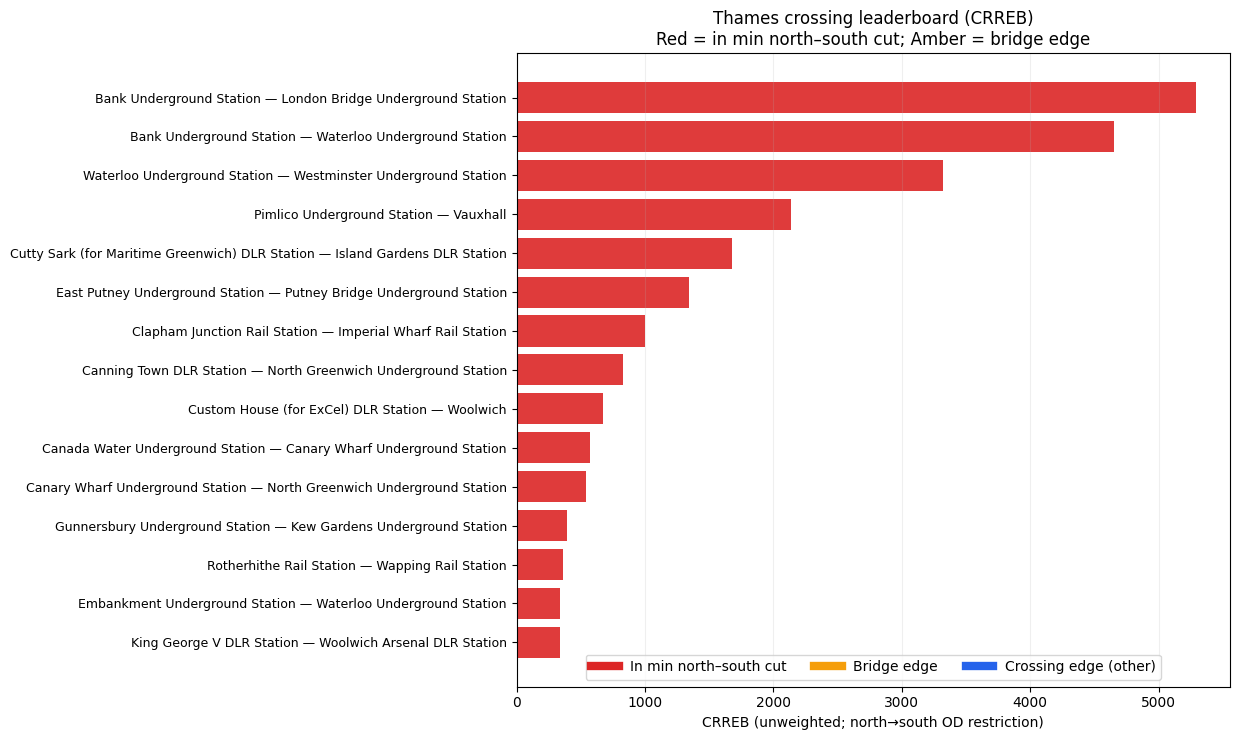

In [47]:
fig6, ax = plt.subplots(figsize=(12.5, 7.5))
y = list(range(len(labels)))
ax.barh(y, vals, color=colors, alpha=0.9)
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=9)
ax.invert_yaxis()
ax.set_xlabel("CRREB (unweighted; north→south OD restriction)")
ax.set_title(
    "Thames crossing leaderboard (CRREB)\nRed = in min north–south cut; Amber = bridge edge"
)
ax.grid(axis="x", alpha=0.2)

handles = [
    plt.Line2D([0], [0], color="#dc2626", lw=6, label="In min north–south cut"),
    plt.Line2D([0], [0], color="#f59e0b", lw=6, label="Bridge edge"),
    plt.Line2D([0], [0], color="#2563eb", lw=6, label="Crossing edge (other)"),
]
ax.legend(handles=handles, loc="lower center", ncol=3)
fig6.tight_layout()